# *RECONSTRUCTION SKILL EVALUATION*

The Analog Method (AM) is a statistical downscaling method very well suited for reconstruction of climatic time series. The reconstruction can reproduce the climatic characteristics of the local phenomena a certain region, based on the relationship between the large scale and the observed local weather patterns.

To validate the quality of the reconstructions is the important to look how the climatic characteristics are reproduced.

This notebook is an example of a fairly complete skill evaluation of the reconstructions and a comparision with the skill of the reanalysis. It contains the following elements:

- Time series skill (Bias, RMSE, R², Brier Score and Taylor diagrams) for daily, monthly and yearly series
- Seasonality
- Equality of distributions
- Daily indices skill

In [1]:
import re
import os
import datetime
import itertools

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import percentileofscore

import rascal.utils
import rascal.analogs
import rascal.indices
import rascal.analysis

In [2]:
reanalysis_dataset = "REA02"
reanalysis_initial_year = 2005
reanalysis_final_year = 2012

station_to_validate = "St03"
variable_to_validate = "TMAX"

# This threshold can be used to calculate the Brier Score and SSMSE 
threshold = 0

In [3]:
# How to group the data when resampling the daily data to monthly or yearly
groupings = {
    "TMEAN": "mean",
    "TMAX": "mean",
    "TMIN": "mean",
    "PCP": "sum"
}

# Name of the predictand variable in the reanalysis files
reanalysis_variables = {
    "TMEAN": ["SURF_T"],
    "TMAX": ["SURF_T"],
    "TMIN": ["SURF_T"],
    "PCP": ["SURF_PCP"]
}

# How to group the reanalysis data to daily resolution
reanalysis_grouping = {
    "TMEAN": "1D_mean",
    "TMAX": "1D_max",
    "TMIN": "1D_min",
    "PCP": "1D_sum"
}

# Units for each variable
units = {
    "TMEAN": "[$^\circ$C]",
    "TMAX": "[$^\circ$C]",
    "TMIN": "[$^\circ$C]",
    "PCP": "[mm]"
}

# Group each year in water years (From October to September) if hydroyear==True
if variable_to_validate == "PCP":
    hydroyear=True
else: 
    hydroyear=False
    
# Variables which reanalysis predictor is part of an ensemble. This is an example of the precipitation for a 
# 10 members ensemble, like in ERA20C
ensemble_variables = ["PCP"]
reanlaysis_ensemble_members = 9

### Paths

In [4]:
if variable_to_validate == "PCP":
    predictor = "SURF_71.162andSURF_72.162-SURF_71.162andSURF_72.162-1"
elif variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    predictor = "925_Z-SURF_T-1"

observations_directory = "./data/observations/"
reanalysis_directory = "./data/reanalysis/ERA5/"
reconstructions_directory = "/".join([".", "output", variable_to_validate, predictor]) + "/"

# 0) LOAD DATA 

To evaluate the skill of the reconstructions the following data is needed:
- Observational data: To compare the reconstructions with the original data.
- Reconstructions: All the different reconstructions for the same variable in the same time, to compare how different methods perform in different tasks.
- Reanalysis data: To compare the added value of using RASCAL instead of using only the reanalysis.

## 0.1) STATION DATA

In [5]:
station = rascal.analogs.Station(path= observations_directory + station_to_validate + '/')
station_daily = station.get_data(variable=variable_to_validate, skipna=False)
station_daily.index.name = "time"

## 0.2) REANALYSIS DATA

Load the reanalysis or reference model data. If the variable is part of an ensemble, all the members of the ensemble are loaded in a single dataframe as "'variable name'_'member number'". Once the data is extracted in the gridpoint of the station, a .csv file is saved, to save computation time in future runs.

In [6]:

reanalysis_data_name = "_".join([station.name, variable_to_validate, reanalysis_dataset + ".csv"])
reanalysis_series_filepath = "/".join([reanalysis_directory, "series", reanalysis_data_name])
reanalysis_original_path = reanalysis_directory

# Load the .csv file if it already exists
if os.path.exists(reanalysis_series_filepath):
    reanalysis_data = pd.read_csv(reanalysis_series_filepath, index_col=0)
    reanalysis_data.index = pd.to_datetime(reanalysis_data.index)
    reanalysis_data.index.name = "time"
    
# If it does not, extract the data in the gridpoint from the original files
else:
    if variable_to_validate in ensemble_variables:
        reanalysis_data = []
        for ensemble_member in range(reanalysis_ensemble_members):
            ensemble_member_data = rascal.analysis.get_reanalysis_in_gridpoint(
                reanalysis_original_path,
                initial_year=reanalysis_initial_year,
                final_year=reanalysis_final_year,
                variable=reanalysis_variables[variable_to_validate],
                grid_point={"lat": station.latitude, "lon": station.longitude},
                file_format=".nc",
                grouping=reanalysis_grouping[variable_to_validate],
                ensemble_member=ensemble_member    
            )
            reanalysis_data.append(ensemble_member_data)
        reanalysis_data = pd.concat(reanalysis_data, axis=1)
        
    else:
        reanalysis_data = rascal.analysis.get_reanalysis_in_gridpoint(
            reanalysis_original_path,
            initial_year=reanalysis_initial_year,
            final_year=reanalysis_final_year,
            variable=reanalysis_variables[variable_to_validate],
            grid_point={"lat": station.latitude, "lon": station.longitude},
            file_format=".nc",
            grouping=reanalysis_grouping[variable_to_validate],
            ensemble_member=None 
        )

    reanalysis_data.to_csv(reanalysis_data_name)


Function 'get_files' executed in 0.0003s
Function 'open_data' executed in 7.9306s


In [7]:
reanalysis_data

,SURF_T
time,
2005-01-01,281.803711
2005-01-02,281.298096
2005-01-03,280.177734
2005-01-04,279.151611
2005-01-05,280.111572
...,...
2012-12-27,281.131836
2012-12-28,283.626953
2012-12-29,277.944824


**Note:** *.get_reanalysis_ensemble()* obtains all the possible reanalysis data of the selected variable, Its adapted to read ensemble data, but it does not have to be in order to work 

In [8]:
reanalysis_daily = rascal.analysis.get_reanalysis_ensemble(
    reanalysis_data, 
    variable_to_validate=variable_to_validate,
    freq="1D", 
    grouping=groupings[variable_to_validate]
)

Index(['SURF_T'], dtype='object')


In [9]:
reanalysis_daily

,SURF_T
time,
2005-01-01,281.803711
2005-01-02,281.298096
2005-01-03,280.177734
2005-01-04,279.151611
2005-01-05,280.111572
...,...
2012-12-27,281.131836
2012-12-28,283.626953
2012-12-29,277.944824


In [10]:
reanalysis_daily.columns = [
    c.replace(reanalysis_variables[variable_to_validate][0], variable_to_validate) for c in reanalysis_daily.columns
]        
    
# Change units
# Kelvin to Celsius
if variable_to_validate in ["TMAX", "TMIN", "TMEAN"]:
    reanalysis_daily = reanalysis_daily - 273.1
# m to mm
elif variable_to_validate == "PCP":
    reanalysis_daily = reanalysis_daily * 1000

In [11]:
reanalysis_daily

,TMAX
time,
2005-01-01,8.703705
2005-01-02,8.198090
2005-01-03,7.077728
2005-01-04,6.051605
2005-01-05,7.011566
...,...
2012-12-27,8.031830
2012-12-28,10.526947
2012-12-29,4.844818


## 0.3) RECONSTRUCTIONS DATA

**Note:** *.get_reconstruction_ensemble()* obtains all the reconstructions with different methods and parameters of the selected variable, Its adapted to read ensemble data, but it does not have to be in order to work 

In [12]:
reconstructions_daily = rascal.analysis.get_reconstruction_ensemble(
    filepath=reconstructions_directory,
    station_to_validate=station_to_validate, 
    variable_to_validate=variable_to_validate,
    freq='1D',
    grouping=groupings[variable_to_validate]
)

In [13]:
reconstructions_daily

,TMAX_average02,TMAX_average05,TMAX_average10,TMAX_closest,TMAX_quantilemap020,TMAX_quantilemap050,TMAX_quantilemap100
time,,,,,,,
2005-01-01,3.599563,4.447727,4.433301,2.5,3.800,4.400,4.6
2005-01-02,3.800000,4.285683,3.637498,3.8,3.400,3.600,3.7
2005-01-03,-0.228450,3.359253,4.040224,-3.3,1.007,2.000,2.8
2005-01-04,4.497587,5.045365,6.373526,4.6,3.500,2.400,1.7
2005-01-05,4.243711,4.880461,5.866857,4.6,3.200,3.100,2.5
...,...,...,...,...,...,...,...
2014-12-27,5.135316,5.302191,5.128401,6.8,1.800,1.500,0.0
2014-12-28,2.143992,1.038841,0.610038,3.4,1.100,0.900,1.0
2014-12-29,1.021542,0.703072,0.833903,0.3,1.700,0.300,0.4


## 0.4) DAILY, MONTHLY AND YEARLY FREQUENCY

The ***RSkill*** class stores the observational, reanalysis, and reconstructions data, and performs various skill metrics calculations

In [14]:
# Daily data 
rskill = rascal.analysis.RSkill(
    observations=station_daily,
    reconstructions=reconstructions_daily,
    reanalysis=reanalysis_daily
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=True)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping=groupings[variable_to_validate], hydroyear=hydroyear, skipna=True)

**NOTE:** If the observation series contains few years or has many gaps, setting $\color{blue}{\text{skipna}}$ to $\color{red}{\text{False}}$ may result in a resampled series that is empty or contains too few points. 

In [15]:
rskill_1y.data

,TMAX_observation,TMAX_reanalysis,TMAX_average02_reconstructions,TMAX_average05_reconstructions,TMAX_average10_reconstructions,TMAX_closest_reconstructions,TMAX_quantilemap020_reconstructions,TMAX_quantilemap050_reconstructions,TMAX_quantilemap100_reconstructions
time,,,,,,,,,
2005-12-31,11.182686,16.522100,9.628896,9.692006,9.791439,9.471121,9.468104,9.393268,9.341545
2006-12-31,14.070720,17.120716,9.806237,9.936579,10.076284,9.768474,10.065342,10.015173,9.977989
2007-12-31,12.278469,16.249184,10.357807,10.257177,10.323054,10.307805,9.374493,9.269879,9.197721
2008-12-31,9.278371,15.955318,9.829023,9.843042,9.911166,9.718219,9.088667,8.934221,8.872735
2009-12-31,9.870556,17.334864,10.192140,10.117619,10.132346,10.227444,10.075682,10.094852,10.082197
2010-12-31,8.184943,15.701284,9.204190,9.300942,9.413781,9.110581,8.877529,8.774622,8.661260
2011-12-31,9.806111,17.431267,10.439259,10.581907,10.698933,10.459216,10.717797,10.529890,10.431970
2012-12-31,8.966758,16.751741,9.848252,9.991277,10.024549,9.977970,9.631055,9.658303,9.662462
2013-12-31,8.045479,NaN,9.703189,9.748223,9.864051,9.478603,9.277096,9.177915,9.094337


# 1) TIME SERIES

## 1.1) Daily time series

TMAX_reanalysis


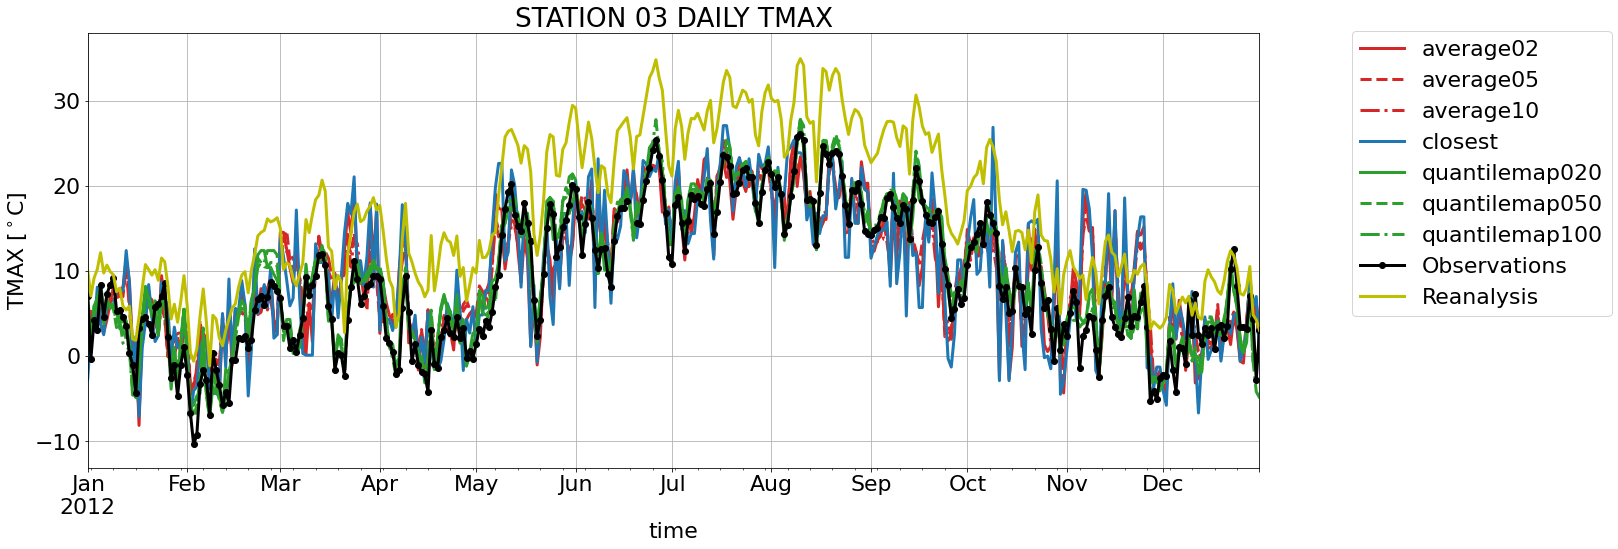

In [16]:
daily_series_plot_start = datetime.datetime(2012, 1, 1)
daily_series_plot_end = datetime.datetime(2012, 12, 31)

fig, ax = rskill.plotseries(start=daily_series_plot_start, end=daily_series_plot_end)
ax.set_title(station.name.upper() + " DAILY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.2) Daily skill table

In [17]:
_, daily_skill = rskill.skill(threshold=threshold)

In [18]:
daily_skill

,bias,rmse,r2,std,bs
TMAX_average02_reconstructions,-0.278232,4.974198,0.797283,7.416891,0.099742
TMAX_average05_reconstructions,-0.316176,4.510251,0.830319,7.089603,0.096191
TMAX_average10_reconstructions,-0.395767,4.325259,0.844088,6.93691,0.097159
TMAX_closest_reconstructions,-0.227863,5.615606,0.752582,7.851076,0.120077
TMAX_quantilemap020_reconstructions,-0.097256,2.158205,0.963227,7.688595,0.061653
TMAX_quantilemap050_reconstructions,-0.025697,1.97664,0.96927,7.791053,0.062944
TMAX_quantilemap100_reconstructions,0.029365,1.936668,0.970668,7.855359,0.061007
TMAX_reanalysis,-6.913282,7.289659,0.967931,8.789528,0.105551


## 1.3) Daily Taylor diagram

(<Figure size 360x360 with 1 Axes>,
 <rascal.analysis.TaylorDiagram at 0x7fa83c378220>)

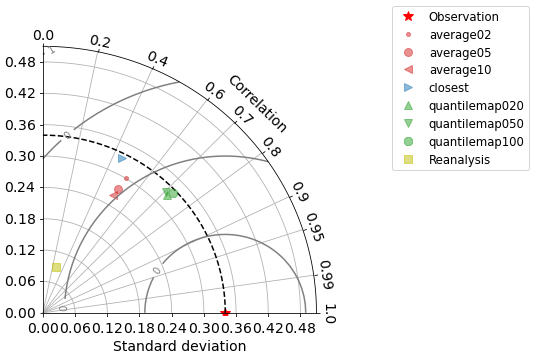

In [42]:
rskill.taylor()

## 1.4) Monthly time series

TMAX_reanalysis


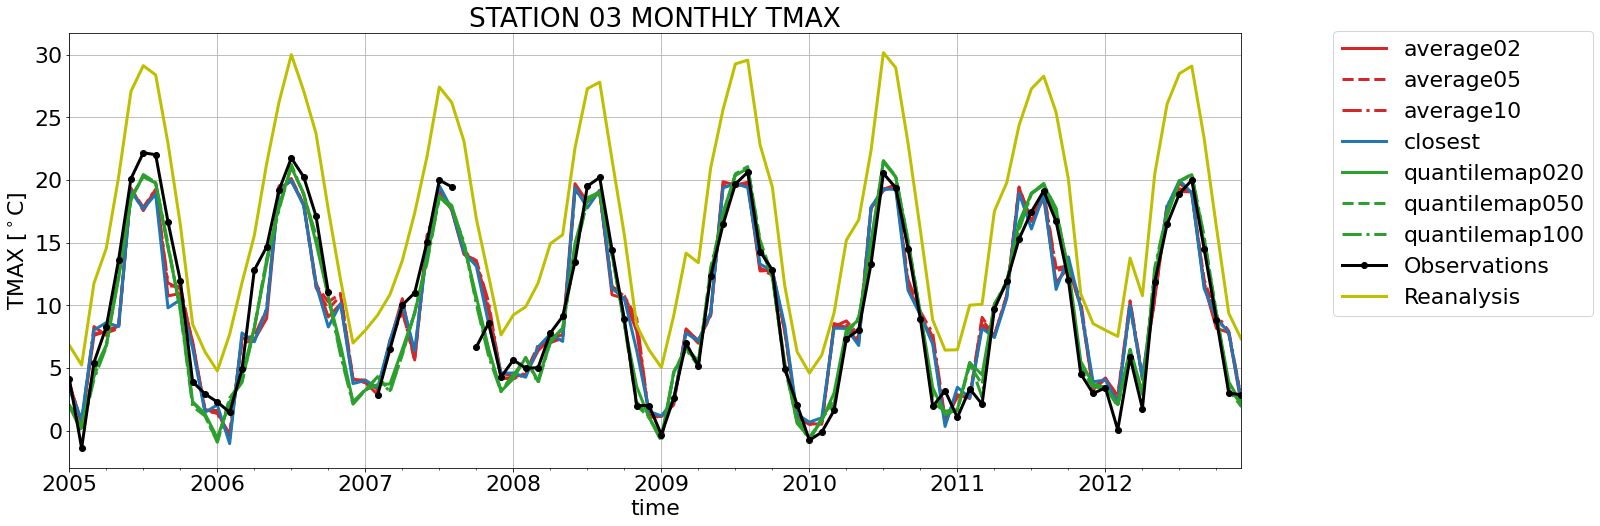

In [20]:
monthly_series_plot_start = datetime.datetime(2005, 1, 1)
monthly_series_plot_end = datetime.datetime(2012, 12, 31)

fig, ax = rskill_1m.plotseries(start=monthly_series_plot_start, end=monthly_series_plot_end)
ax.set_title(station.name.upper() + " MONTHLY " + variable_to_validate)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.5) Monthly skill table

In [21]:
_, monthly_skill = rskill_1m.skill()

In [22]:
monthly_skill

,bias,rmse,r2,std,bs
TMAX_average02_reconstructions,-0.282718,2.807464,0.913594,6.119527,7.881855
TMAX_average05_reconstructions,-0.328042,2.779925,0.915736,6.122454,7.727984
TMAX_average10_reconstructions,-0.414636,2.814135,0.914244,6.128152,7.919355
TMAX_closest_reconstructions,-0.233864,2.771688,0.915815,6.073069,7.682255
TMAX_quantilemap020_reconstructions,-0.074374,1.452856,0.977422,6.696136,2.110789
TMAX_quantilemap050_reconstructions,-0.000509,1.430479,0.978117,6.764458,2.046270
TMAX_quantilemap100_reconstructions,0.052547,1.423666,0.978445,6.80962,2.026826
TMAX_reanalysis,-6.850699,7.094554,0.979553,7.927424,50.332691


## 1.6) Monthly Taylor diagram

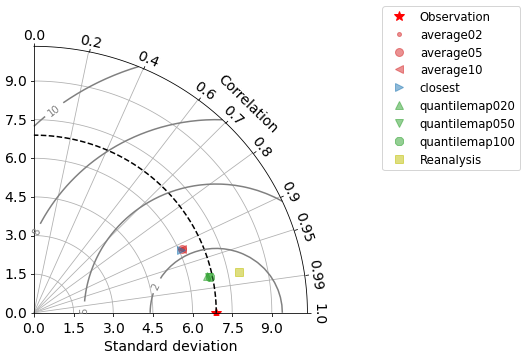

In [23]:
fig, diag = rskill_1m.taylor()

## 1.7) Yearly time series

**NOTE:** In this example, the years 2006 and 2007 contains too many gaps in winter. Since $\color{blue}{\text{skipna}}$ was set to $\color{green}{\text{True}}$, this resuls in a couple of heavy warm biased years that affects the skill metrics.

TMAX_reanalysis


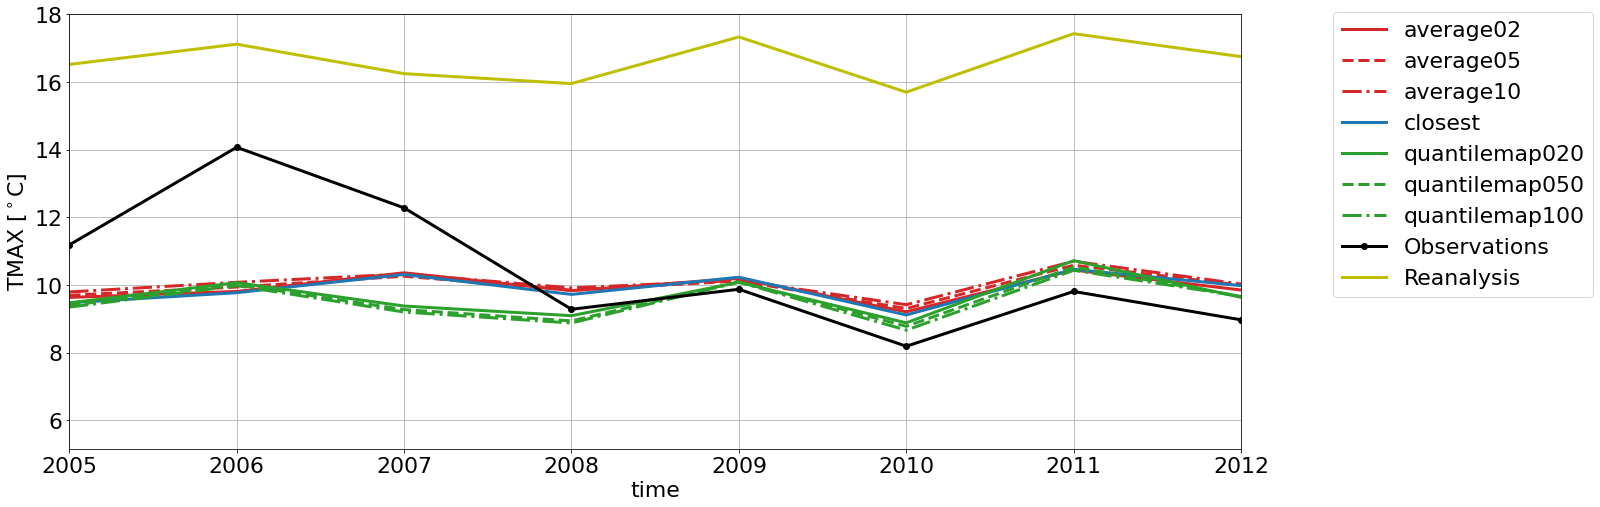

In [24]:
yearly_series_plot_start = datetime.datetime(2005, 1, 1)
yearly_series_plot_end = datetime.datetime(2012, 12, 31)

fig, ax = rskill_1y.plotseries(start=yearly_series_plot_start, end=yearly_series_plot_end)
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])
plt.show()

## 1.8) Yearly skill table

In [25]:
_, yearly_skill = rskill_1y.skill()

In [26]:
yearly_skill

,bias,rmse,r2,std,bs
TMAX_average02_reconstructions,-0.106964,2.09006,0.441777,0.367201,4.368349
TMAX_average05_reconstructions,-0.157226,2.09573,0.449477,0.349242,4.392084
TMAX_average10_reconstructions,-0.242703,2.096106,0.47587,0.343353,4.393662
TMAX_closest_reconstructions,-0.063843,2.108706,0.367581,0.408532,4.446641
TMAX_quantilemap020_reconstructions,0.124178,2.138065,0.285098,0.514395,4.571321
TMAX_quantilemap050_reconstructions,0.191907,2.164351,0.244855,0.521309,4.684413
TMAX_quantilemap100_reconstructions,0.242596,2.180246,0.224919,0.535717,4.753472
TMAX_reanalysis,-6.178483,6.41405,0.320377,0.598829,41.140034


## 1.9) Yearly Taylor diagram

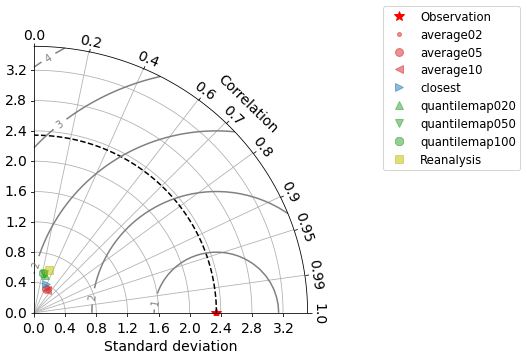

In [27]:
fig, ax = rskill_1y.taylor()

# 2) SEASONALITY

## 2.1) Variable Annual Cycle

Text(0, 0.5, 'TMAX [$^\\circ$C]')

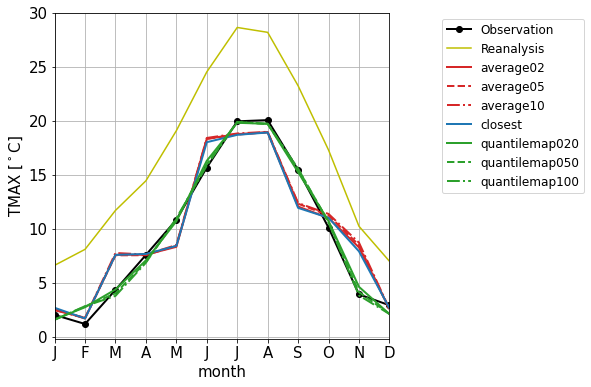

In [28]:
fig, ax = rskill_1m.annual_cycle(grouping="mean")
ax.set_xlabel("month")
ax.set_ylabel(variable_to_validate + " " + units[variable_to_validate])

## 2.2) Variable Standard Deviation Annual Cycle

Text(0, 0.5, 'TMAX std [$^\\circ$C]')

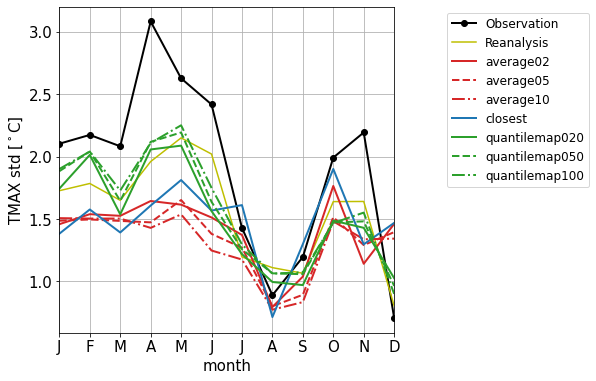

In [29]:
fig, ax = rskill_1m.annual_cycle(grouping="std")
ax.set_xlabel("month")
ax.set_ylabel(variable_to_validate + " std " + units[variable_to_validate])

# 3) DISTRIBUTIONS

## 3.1) Daily Quantile-Quantile Diagram

Text(0.5, 0, 'TMAX daily reconstruction [$^\\circ$C]')

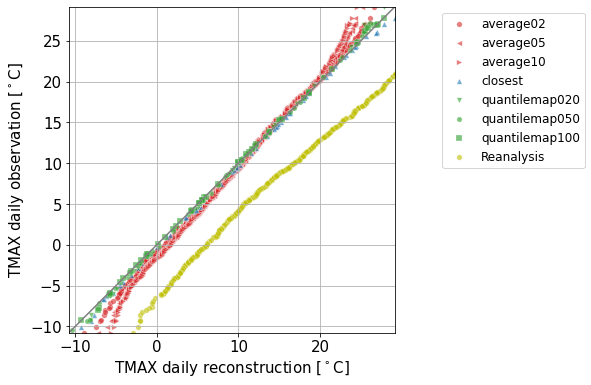

In [30]:
fig, ax = rskill.qqplot()
ax.set_ylabel(variable_to_validate + " daily observation " + units[variable_to_validate])
ax.set_xlabel(variable_to_validate + " daily reconstruction " + units[variable_to_validate])

# 4) INDICES

Since RASCAL is designed to work with daily resolution, it allows the calculation of relevant weather indices. This can be done with the class ***CIndex***, and the following indices can be calculated

| Index | Shortname | Variables | Definition |
| --- | --- | --- | --- |
| Frost days | fd | $T_{min}$ | $T_{min}$ < 0$^\circ$C |
| Tropical nights | tr | $T_{min}$ | $T_{min}$ > 20$^\circ$C |
| Summer days | su | $T_{max}$ | $T_{max}$ > 25$^\circ$C |
| Icing days | id | $T_{max}$ | $T_{max}$ < 0$^\circ$C |
| R10mm | r10mm | $PCP$ | $PCP$ $\geq$ 10 mm |
| R20mm | r20mm | $PCP$ | $PCP$ $\geq$ 20 mm |
| Rnnmm | rnnmm | $PCP$ | $PCP$ $\geq$ N mm |
| Consecutive Dry Days | cdd | $PCP$ |  Maximum length of dry spell $(RR < 1 mm)$ |
| Consecutive Wet Days | cwd | $PCP$ |  Maximum length of wet spell $(RR ≥ 1 mm)$ |

In [31]:
climatic_index = "id"

In [32]:
index_name = {
    "fd": "frost days  ($T_{min}$ < 0$^\circ$C)",
    "su": "summer days ($T_{max}$ > 25$^\circ$C)",
    "id": "icing days ($T_{max}$ < 0$^\circ$C)",
    "tr": "tropical nigths ($T_{min}$ > 20$^\circ$C)",
    "r10mm": "R10mm (PCP $\geq$ 10 mm)",
    "r20mm": "R20mm (PCP $\geq$ 20 mm)",
    "rnnmm": "R1mm (PCP $\geq$ 1 mm)",
    "cdd": "consecutive dry days",
    "cwd": "consecutive wet days",
}

In [33]:
station_indices = rascal.indices.CIndex(station_daily)
reconstruction_indices = rascal.indices.CIndex(reconstructions_daily)
reanalysis_indices = rascal.indices.CIndex(reanalysis_daily)

In [34]:
call_obs_idx = getattr(station_indices, climatic_index)
call_rec_idx = getattr(reconstruction_indices, climatic_index)
call_rea_idx = getattr(reanalysis_indices, climatic_index)

obs_idx = call_obs_idx()
rec_idx = call_rec_idx()
rea_idx = call_rea_idx()

In [35]:
# Daily data 
rskill = rascal.analysis.RSkill(
    observations=obs_idx,
    reconstructions=rec_idx,
    reanalysis=rea_idx
)

# Monthly data
rskill_1m = rskill.resample(freq="1m", grouping="sum", hydroyear=False, skipna=False)

# Yearly data
rskill_1y = rskill.resample(freq="1Y", grouping="sum", hydroyear=False, skipna=True)

ID_reanalysis


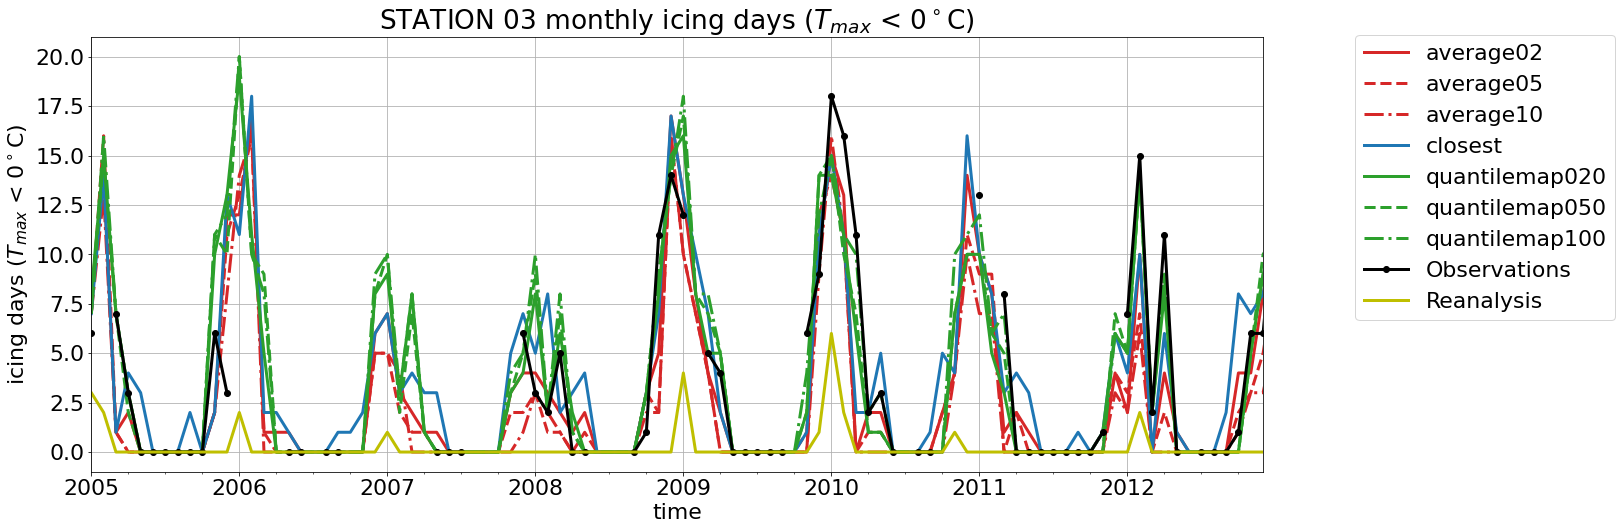

In [36]:
monthly_index_plot_start = datetime.datetime(2005, 1, 1)
monthly_index_plot_end = datetime.datetime(2012, 12, 31)

fig, ax = rskill_1m.plotseries(start=monthly_index_plot_start, end=monthly_index_plot_end)
ax.set_title(station.name.upper() + " monthly " + index_name[climatic_index])
ax.set_ylabel(index_name[climatic_index])
plt.show()

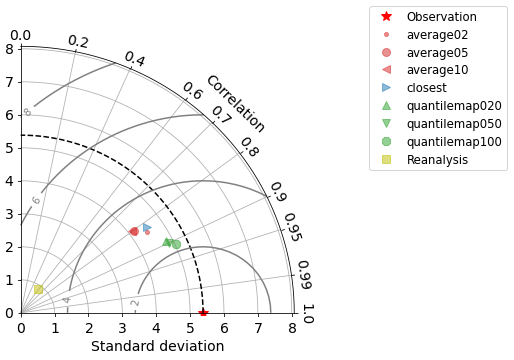

In [37]:
fig, diag = rskill_1m.taylor()

In [38]:
models = ["observation", "reanalysis", "quantilemap100"]

In [39]:
monthly_indices = []
for col in rskill_1m.data.columns:
    index = rskill_1m.data[col].to_frame().rename(columns={col: climatic_index})
    index["dataset"] = col.split("_")[1]
    monthly_indices.append(index)
monthly_indices = pd.concat(monthly_indices, axis=0)
monthly_indices["month"] = monthly_indices.index.month
monthly_indices["year"] = monthly_indices.index.year
monthly_indices = monthly_indices.loc[monthly_indices["dataset"].isin(models)]
monthly_indices

,id,dataset,month,year
time,,,,
2005-01-31,6.0,observation,1,2005
2005-02-28,NaN,observation,2,2005
2005-03-31,7.0,observation,3,2005
2005-04-30,3.0,observation,4,2005
2005-05-31,0.0,observation,5,2005
...,...,...,...,...
2014-08-31,0.0,quantilemap100,8,2014
2014-09-30,0.0,quantilemap100,9,2014
2014-10-31,0.0,quantilemap100,10,2014


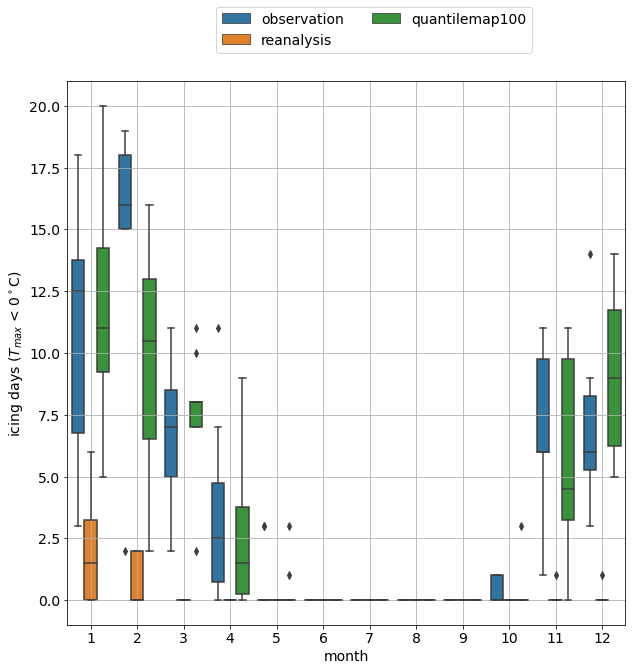

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()

sns.boxplot(data=monthly_indices, x="month", y=climatic_index, ax=ax, hue="dataset")
ax.set_ylabel(index_name[climatic_index])    
ax.legend(bbox_to_anchor=[0.55, 1.15], loc="upper center", ncol=2)
ax.grid()